# Markov Model: Core Concepts and Elements

# https://eudml.org/doc/128778

# https://www.jstor.org/stable/2238772

A **Markov Model** is a mathematical framework for modeling systems that evolve over time, where the **next state depends only on the current state** (the *Markov property*).

---

## 1. States (S)
- A finite set of possible situations the system can be in.  
- Example: {Sunny, Rainy} in a weather model.  
- Notation:  

$$
S = \{s_1, s_2, \dots, s_N\}
$$

---

## 2. Initial State Distribution (π)
- The probability distribution over states at the starting time \(t=0\).  
- Example:  

$$
\pi = [0.7, 0.3]
$$

meaning 70% Sunny, 30% Rainy.  
- Notation:  

$$
\pi_i = P(X_0 = s_i)
$$

---

## 3. Transition Probabilities (A)
- A matrix defining probabilities of moving from one state to another.  
- Example:  

$$
P(\text{Rainy}_{t+1} \mid \text{Sunny}_t) = 0.2
$$

- Properties:  

$$
a_{ij} \geq 0, \quad \sum_{j=1}^N a_{ij} = 1
$$

- Example transition matrix:  

$$
A = \begin{bmatrix}
0.8 & 0.2 \\
0.4 & 0.6
\end{bmatrix}
$$

---

## 4. Observations (O)
- The outputs we can actually see.  
- In a **Markov Chain**, the states themselves are observed.  
- In a **Hidden Markov Model (HMM)**, we only see *symbols* or *features* emitted by the hidden states.

---

## 5. Emission Probabilities (B) (HMM only)
- Defines the probability of observing a symbol given the hidden state.  
- Example: If the state is Rainy, probability of observation "Walk" = 0.1.  
- Notation:  

$$
b_i(o_k) = P(O_t = o_k \mid X_t = s_i)
$$

- Example emission matrix:  

$$
B = \begin{bmatrix}
0.6 & 0.3 & 0.1 \\
0.1 & 0.4 & 0.5
\end{bmatrix}
$$

---

## 6. Time Parameter (t)
- The model evolves in discrete time steps:  

$$
t = 0, 1, 2, \dots
$$

- At each step:  
  1. The system is in some state.  
  2. It may emit an observation (in HMM).  
  3. It transitions to the next state.

---

## Summary
- **Markov Chain**  

$$
\{ S, \pi, A \}
$$

- **Hidden Markov Model (HMM)**  

$$
\{ S, \pi, A, O, B \}
$$

This framework is widely used in **speech recognition, bioinformatics, natural language processing, and finance**, where sequential data must be modeled probabilistically.


In [ ]:
# ===========================================================
# Full PyTorch Lab: Markov Models & Hidden Markov Models
# -----------------------------------------------------------
# Covers:
# - Markov Chain
# - Hidden Markov Model (HMM)
# - Transition, Emission, Initial Distribution
# - Sampling, Likelihood (Forward Algorithm)
# - Visualizations (heatmaps, sequences, frequencies)
# ===========================================================

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import random

# -----------------------------
# Markov Chain
# -----------------------------
class MarkovChain:
    def __init__(self, transition_matrix, initial_probs, state_labels=None):
        self.A = transition_matrix
        self.pi = initial_probs
        self.N = transition_matrix.shape[0]
        self.state_labels = state_labels if state_labels else [f"S{i}" for i in range(self.N)]

    def sample(self, T=10):
        states = []
        s = torch.multinomial(self.pi, 1).item()
        states.append(s)
        for _ in range(T-1):
            s = torch.multinomial(self.A[states[-1]], 1).item()
            states.append(s)
        return states

    def visualize_matrix(self):
        plt.figure(figsize=(6,5))
        sns.heatmap(self.A.numpy(), annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=self.state_labels, yticklabels=self.state_labels)
        plt.title("Transition Matrix (Markov Chain)")
        plt.show()

# -----------------------------
# Hidden Markov Model (HMM)
# -----------------------------
class HiddenMarkovModel:
    def __init__(self, transition_matrix, emission_matrix, initial_probs,
                 state_labels=None, obs_labels=None):
        self.A = transition_matrix
        self.B = emission_matrix
        self.pi = initial_probs
        self.N = transition_matrix.shape[0]
        self.M = emission_matrix.shape[1]
        self.state_labels = state_labels if state_labels else [f"S{i}" for i in range(self.N)]
        self.obs_labels = obs_labels if obs_labels else [f"O{k}" for k in range(self.M)]

    def sample(self, T=10):
        states, obs = [], []
        s = torch.multinomial(self.pi, 1).item()
        states.append(s)
        o = torch.multinomial(self.B[s], 1).item()
        obs.append(o)
        for _ in range(T-1):
            s = torch.multinomial(self.A[states[-1]], 1).item()
            states.append(s)
            o = torch.multinomial(self.B[s], 1).item()
            obs.append(o)
        return states, obs

    def sequence_likelihood(self, obs_seq):
        T = len(obs_seq)
        alpha = self.pi * self.B[:, obs_seq[0]]
        for t in range(1, T):
            alpha = (alpha @ self.A) * self.B[:, obs_seq[t]]
        return alpha.sum().item()

    def visualize_matrices(self):
        fig, axs = plt.subplots(1, 2, figsize=(12,5))
        sns.heatmap(self.A.numpy(), annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=self.state_labels, yticklabels=self.state_labels, ax=axs[0])
        axs[0].set_title("Transition Matrix")
        sns.heatmap(self.B.numpy(), annot=True, fmt=".2f", cmap="Greens",
                    xticklabels=self.obs_labels, yticklabels=self.state_labels, ax=axs[1])
        axs[1].set_title("Emission Matrix")
        plt.show()

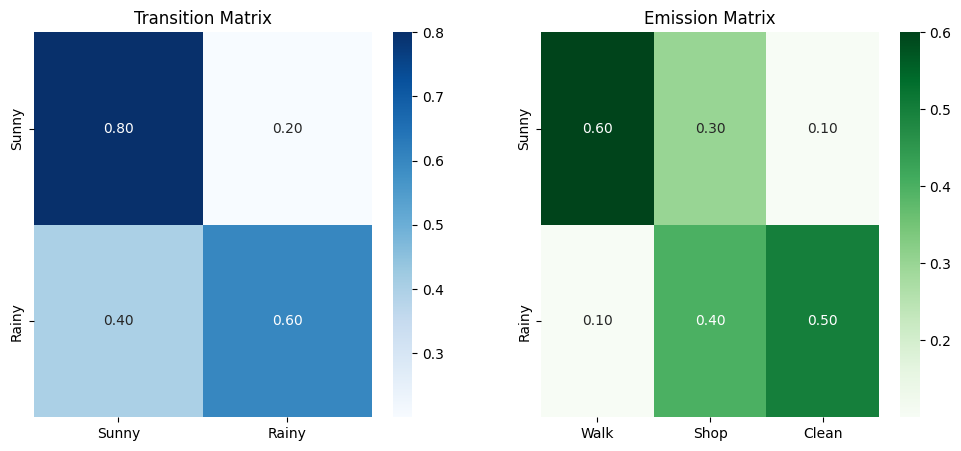

In [ ]:
# -----------------------------
# Example Setup: Weather HMM
# -----------------------------
states = ["Sunny", "Rainy"]
observations = ["Walk", "Shop", "Clean"]

A = torch.tensor([[0.8, 0.2],
                  [0.4, 0.6]])  # transitions
B = torch.tensor([[0.6, 0.3, 0.1],
                  [0.1, 0.4, 0.5]])  # emissions
pi = torch.tensor([0.7, 0.3])  # initial

# Create HMM
hmm = HiddenMarkovModel(A, B, pi, state_labels=states, obs_labels=observations)
hmm.visualize_matrices()

In [ ]:
# -----------------------------
# Sampling from HMM
# -----------------------------
states_seq, obs_seq = hmm.sample(T=10)
print("Hidden States:", [states[s] for s in states_seq])
print("Observations :", [observations[o] for o in obs_seq])

Hidden States: ['Rainy', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Rainy', 'Sunny']
Observations : ['Shop', 'Shop', 'Clean', 'Walk', 'Walk', 'Clean', 'Walk', 'Shop', 'Shop', 'Walk']


In [ ]:
# -----------------------------
# Likelihood of Observation Sequence
# -----------------------------
test_seq = [0, 1, 2]  # Walk -> Shop -> Clean
likelihood = hmm.sequence_likelihood(test_seq)
print("P(Walk, Shop, Clean) =", likelihood)

P(Walk, Shop, Clean) = 0.03266400098800659


Seq 1: ['Clean', 'Walk', 'Walk', 'Walk', 'Walk', 'Walk', 'Walk', 'Walk', 'Walk', 'Walk', 'Shop', 'Shop', 'Shop', 'Clean', 'Walk']
Seq 2: ['Walk', 'Clean', 'Clean', 'Shop', 'Clean', 'Walk', 'Walk', 'Walk', 'Shop', 'Shop', 'Shop', 'Walk', 'Shop', 'Shop', 'Shop']
Seq 3: ['Shop', 'Walk', 'Walk', 'Shop', 'Walk', 'Walk', 'Clean', 'Shop', 'Shop', 'Clean', 'Shop', 'Shop', 'Walk', 'Clean', 'Shop']
Seq 4: ['Shop', 'Walk', 'Walk', 'Clean', 'Walk', 'Walk', 'Shop', 'Clean', 'Shop', 'Shop', 'Walk', 'Clean', 'Walk', 'Clean', 'Shop']
Seq 5: ['Clean', 'Walk', 'Walk', 'Shop', 'Shop', 'Shop', 'Clean', 'Shop', 'Clean', 'Shop', 'Clean', 'Clean', 'Walk', 'Shop', 'Walk']


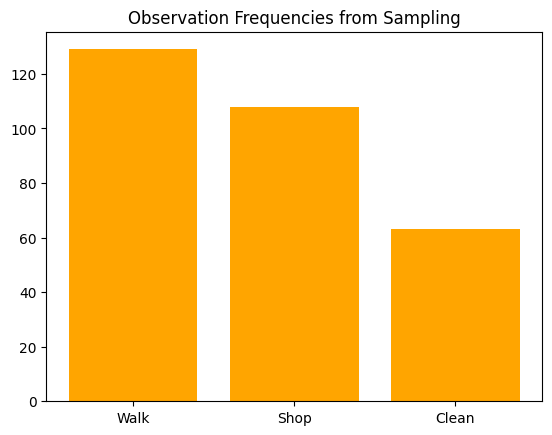

In [ ]:
# -----------------------------
# Multiple Runs & Frequencies
# -----------------------------
all_obs = []
for _ in range(20):
    _, obs_seq = hmm.sample(T=15)
    all_obs.append([observations[o] for o in obs_seq])

for i, seq in enumerate(all_obs[:5]):
    print(f"Seq {i+1}: {seq}")

flat_obs = sum(all_obs, [])
freqs = {obs: flat_obs.count(obs) for obs in observations}

plt.bar(freqs.keys(), freqs.values(), color="orange")
plt.title("Observation Frequencies from Sampling")
plt.show()

# Hidden Markov Model (HMM) Experimental Results

## 1. Transition and Emission Matrices (First Image)
- **Transition Matrix:**
  - Sunny → Sunny = 0.8, Sunny → Rainy = 0.2  
  - Rainy → Rainy = 0.6, Rainy → Sunny = 0.4  
  - **Interpretation:** Weather shows persistence; staying in the same state is more likely than switching.

- **Emission Matrix:**
  - If Sunny: Walk (0.6), Shop (0.3), Clean (0.1)  
  - If Rainy: Walk (0.1), Shop (0.4), Clean (0.5)  
  - **Interpretation:** Observed activities depend on hidden weather states, capturing the defining property of HMMs.

**Insight:** HMMs encode how hidden states drive visible sequences.

---

## 2. Likelihood Computation (Second Image)
- **Observation Sequence:** Walk → Shop → Clean  
- **Computed Probability:** \( P(\text{Walk, Shop, Clean}) \approx 0.0326 \)  

**Interpretation:** HMMs can evaluate the likelihood of observed sequences, a fundamental step in applications such as speech recognition and biological sequence analysis.

---

## 3. Observation Sequences from Sampling (Third & Fourth Images)
- **Setup:** Sampled sequences, each with T = 15 steps.  
- **Observation:** Sequences vary but respect encoded probabilities.  
  - Long streaks of *Walk* when Sunny persists.  
  - More *Clean* when Rainy dominates.  

**Insight:** Demonstrates the **generative capability** of HMMs — they can simulate realistic temporal patterns consistent with their parameters.

---

## 4. Observation Frequency Distribution (Fifth Image)
- **Aggregated over 20 runs:**
  - Walk ≈ 130 occurrences  
  - Shop ≈ 110 occurrences  
  - Clean ≈ 60 occurrences  

**Interpretation:** Frequencies reflect both emission probabilities and hidden state persistence. Walk dominates because it is favored under Sunny, and Sunny is highly persistent (0.8 self-transition).

---

##  Overall Academic Interpretation
- **Transition matrix:** Governs temporal persistence and switching of hidden states.  
- **Emission matrix:** Defines how hidden states produce observable outcomes.  
- **Likelihoods:** Quantify how probable a sequence is under the model.  
- **Sampling:** Shows the HMM’s ability to generate data matching its probabilistic structure.  

**Conclusion:** These results validate the theoretical behavior of HMMs, illustrating why they became foundational tools in **speech recognition, natural language processing, and bioinformatics**.
